<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model Interpretation for Pretrained Model to Recognize Geometric Shapes using KernelSHAP

This notebook demonstrates how to apply the KernelSHAP explainability method on a pretrained model used to classify geometric shapes. The relevance attributions for each pixel/super-pixel are visualized by displaying them on the image. <br>

SHapley Additive exPlanations, in short, SHAP, is a model-agnostic explainable AI approach which is used to decrypt the black-box models through estimating the Shapley values.<br>

KernelSHAP is a variant of SHAP. It is a method that uses the LIME framework to compute Shapley Values.<br>

More details about this method can be found in the paper https://arxiv.org/abs/1705.07874.

In [1]:
import warnings
warnings.filterwarnings('ignore') # disable warnings relateds to versions of tf
import numpy as np
import dianna
import onnx
from onnx_tf.backend import prepare
import matplotlib.pyplot as plt
from pathlib import Path

#### 1 - Loading the model and the dataset
Loads pretrained model and the image to be explained.

Load saved geometric shapes data.

In [2]:
# load dataset
data = np.load(Path('data', 'shapes.npz'))
# load testing data and the related labels
X_test = data['X_test'].astype(np.float32).reshape([-1, 1, 64, 64])
y_test = data['y_test']

Load the pretrained binary MNIST model.

In [3]:
# Load saved onnx model
onnx_model_path = Path('models', 'geometric_shapes_model.onnx')
onnx_model = onnx.load(onnx_model_path)
# get the output node
output_node = prepare(onnx_model, gen_tensor_dict=True).outputs[0]

Print class and image of a single instance in the test data for preview.

The predicted class is: triangle


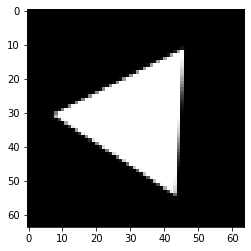

In [4]:
# class name
class_name = ['circle', 'triangle']
# instance index
i_instance = 4
# select instance for testing
test_sample = X_test[i_instance].copy().astype(np.float32)
# model predictions with added batch axis to test sample
predictions = prepare(onnx_model).run(test_sample[None, ...])[f'{output_node}']
pred_class = class_name[np.argmax(predictions)]
print("The predicted class is:", pred_class)
plt.imshow(X_test[i_instance][0,:,:], cmap='gray')

#### 2 - Compute Shapley values and visualize the relevance attributions
Approximate Shapley values using KernelSHAP and visualize the relevance attributions on the image. <br>

KernelSHAP approximate Shapley values in the LIME framework.
The user need to specified the number of times to re-evaluate the model when explaining each prediction (`nsamples`). A binary mask need to be applied to the image to represent if an image region is hidden. It requires the background color for the masked image, which can be specified by `background`.<br>

Performing KernelSHAP on each pixel is inefficient. It is always a good practice to segment the input image and perform computations on the obtained superpixels. This requires the user to specify some keyword arguments related to the segmentation, like the (approximate) number of labels in the segmented output image (`n_segments`), and width of Gaussian smoothing kernel for pre-processing for each dimension of the image (`sigma`).

In [5]:
# use KernelSHAP to explain the network's predictions
shap_values, segments_slic = dianna.explain_image(onnx_model_path, test_sample,
                                                  method="KernelSHAP", labels=[1], nsamples=2000,
                                                  n_segments=200, sigma=0,
                                                  axis_labels=('channels','height','width'))

  0%|          | 0/1 [00:00<?, ?it/s]

Define a function to fill each pixel with shap values based on the segmentation. <br>
This function is used to make plots.

In [6]:
# fill each pixel with SHAP values 
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

Visualize Shapley scores on the images.

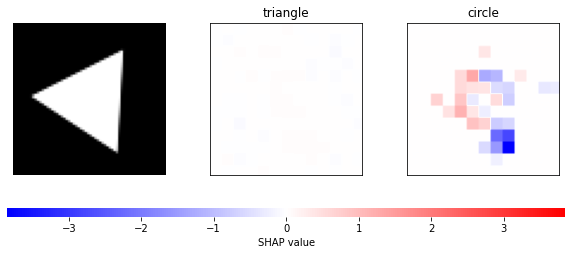

In [7]:
# get the index of predictions
top_preds = np.argsort(-predictions)
inds = top_preds[0]
# Visualize the explanations
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
axes[0].imshow(test_sample[0], cmap='gray')
axes[0].axis('off')
# get the range for color bar
max_val = np.max([np.max(np.abs(shap_values[i][:,:-1])) for i in range(len(shap_values))])
# plot the test image and the attributions on the image for each class
for i in range(2):
    m = fill_segmentation(shap_values[inds[i]][0], segments_slic)
    axes[i+1].set_title(class_name[inds[i]])
    axes[i+1].imshow(test_sample[0], alpha=0.15)
    im = axes[i+1].imshow(m, cmap='bwr',vmin=-max_val, vmax=max_val)
    #axes[i+1].axis('off')
    axes[i+1].set_xticks([])
    axes[i+1].set_yticks([])
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

#### 3 - Conclusions
The Shapley scores are estimated using KernelSHAP. The example here shows that the KernelSHAP method evaluates the importance of each segmentations/super pixels to the classification of geometric shapes and the results indicate that the model determines the shape by checking whether there is a (sharp) angle or not. For instance, the figure above shows that the sharp angle leads to negative scores against circle, and therefore the prediction is triangle. The interpretation agrees with the human visual preception of the chosen image.
